<a href="https://colab.research.google.com/github/miguel-kjh/T-SNE/blob/main/TSNE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# t-SNE
t-Distributed Stochastic Neighbor Embedding (t-SNE)

Buen vídeo básico de introducción al t-SNE
https://www.youtube.com/watch?v=NEaUSP4YerM

https://towardsdatascience.com/an-introduction-to-t-sne-with-python-example-5a3a293108d1

In [71]:
import torch
import math
import numpy as np
from sklearn import datasets
import plotly.express as px
import matplotlib.pyplot as plt
import pandas as pd

device = 'cpu'

In [63]:
distT_torch = torch.distributions.studentT.StudentT(df=1, loc=0, scale=1)

def distance(p1,p2):
    return torch.sqrt(torch.sum((p1 - p2)**2) + 1e-6)
    
def pdf(x):
    return torch.exp(distT_torch.log_prob(x))

def KL(p, q):
    return torch.where(q > 0.1e-8, p * torch.log(p/q), torch.tensor([0.], dtype=torch.double, device=device)).sum()

In [88]:
def T_SNE(Q_points,Y, num_dim=2, epochs=250):
  print(num_dim, Q_points.shape )
  if Q_points.shape[1] <= num_dim:
     raise ValueError("---")
  P_points = np.random.uniform(Q_points.min(), Q_points.max(), size=(Q_points.shape[0],num_dim))
  
  P = torch.tensor(P_points, requires_grad=True, dtype=torch.float, device=device)
  Q = torch.tensor(Q_points, dtype=torch.float, device=device)
  optimizer = torch.optim.Adam([P], lr=0.1)

  for c, _ in enumerate(range(epochs)):
      
      PM = torch.tensor(np.zeros((len(P_points), len(P_points))), dtype=float, device=device)
      QM = torch.tensor(np.zeros((len(P_points), len(P_points))), dtype=float, device=device)
      
      for i,p in enumerate(Q):
          for j,q in enumerate(Q):
              QM[i,j] = distance(p,q)
      
      QD = pdf(QM)
      QD = torch.div(QD.t(), torch.sum(QD, dim=1)).t()
          
      for i,p in enumerate(P):
          for j,q in enumerate(P):
              PM[i,j] = distance(p,q)

      PD = pdf(PM)
      PD = torch.div(PD.t(), torch.sum(PD, dim=1)).t()
          
      loss = torch.tensor([0.], device=device)
      for pd, qd in zip(PD, QD):
          loss += KL(pd, qd)
      
      if c%10 == 0:
          print("Epoch:", c, "loss:", loss.item())
          if num_dim == 2:
            resultThisEpochs = P.cpu().detach().numpy()
            plt.scatter(resultThisEpochs[:,0], resultThisEpochs[:,1], c=y)
            plt.show()
      

      loss.backward()   
      optimizer.step()    
      optimizer.zero_grad()

  return P.cpu().detach().numpy()

In [65]:
iris = datasets.load_iris()
x = iris.data
y = iris.target
print(x.shape)

(150, 4)


# 2D

Epoch: 0 loss: 153.7899932861328


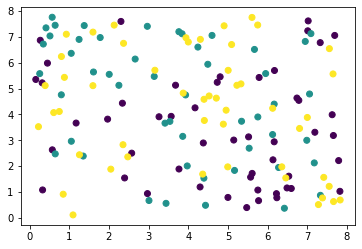

Epoch: 10 loss: 109.79530334472656


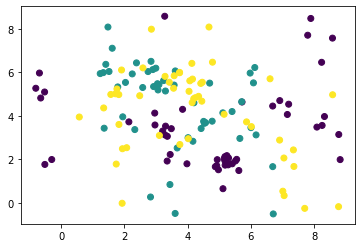

Epoch: 20 loss: 78.379150390625


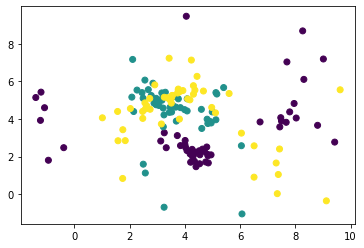

Epoch: 30 loss: 60.431514739990234


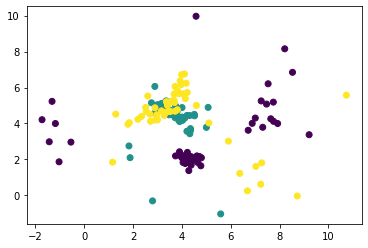

Epoch: 40 loss: 48.63347625732422


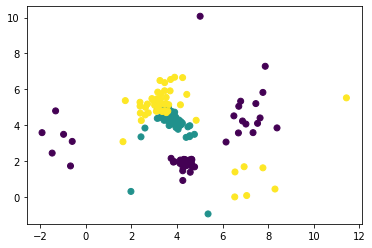

Epoch: 50 loss: 40.098052978515625


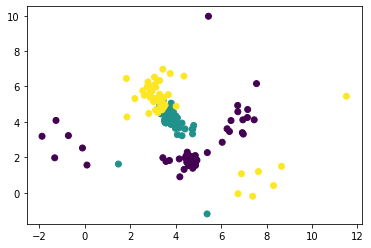

Epoch: 60 loss: 33.134803771972656


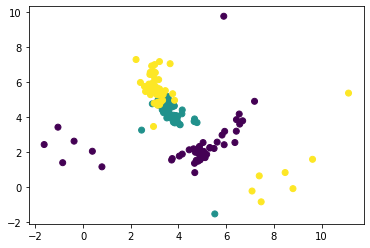

Epoch: 70 loss: 26.943143844604492


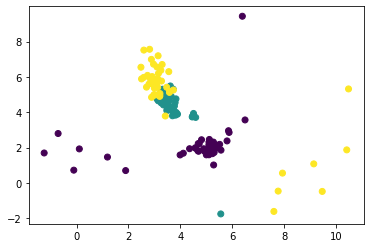

Epoch: 80 loss: 23.507179260253906


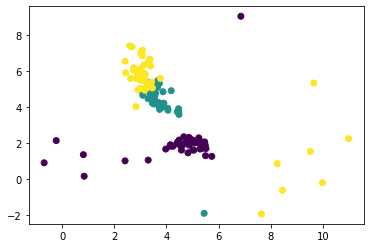

Epoch: 90 loss: 20.28470230102539


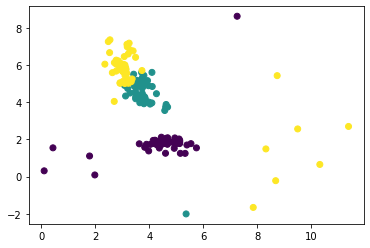

Epoch: 100 loss: 17.272907257080078


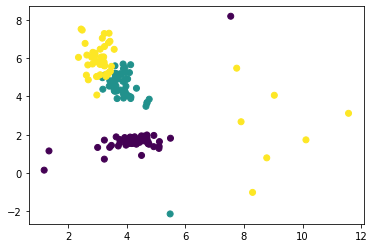

Epoch: 110 loss: 13.356027603149414


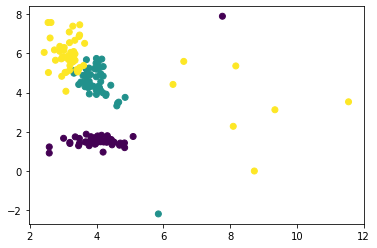

Epoch: 120 loss: 10.342756271362305


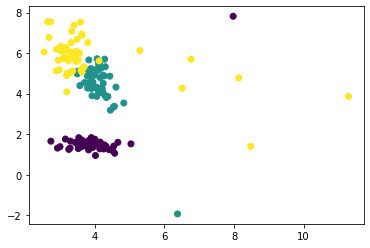

Epoch: 130 loss: 7.526397228240967


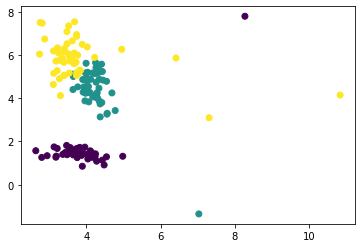

Epoch: 140 loss: 5.408759117126465


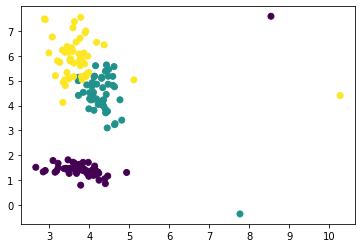

Epoch: 150 loss: 5.071979522705078


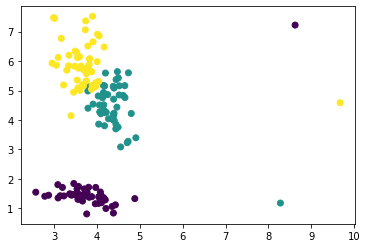

Epoch: 160 loss: 4.587762832641602


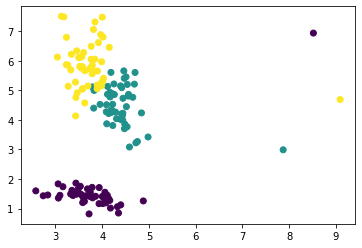

Epoch: 170 loss: 3.7517993450164795


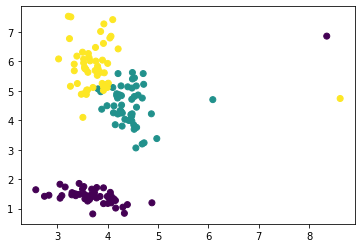

Epoch: 180 loss: 3.412358283996582


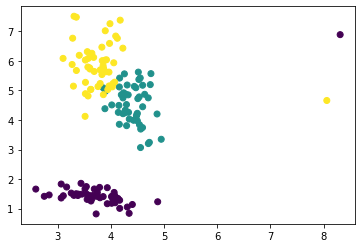

Epoch: 190 loss: 3.258575677871704


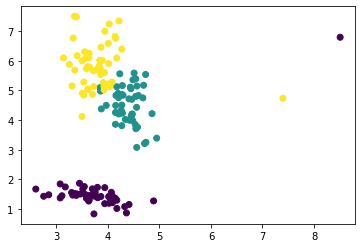

Epoch: 200 loss: 3.0790555477142334


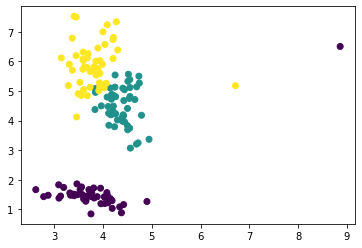

Epoch: 210 loss: 2.783860445022583


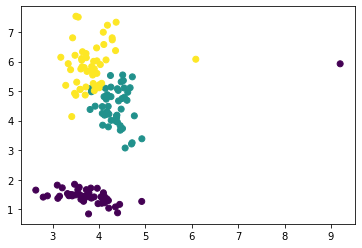

Epoch: 220 loss: 2.416667938232422


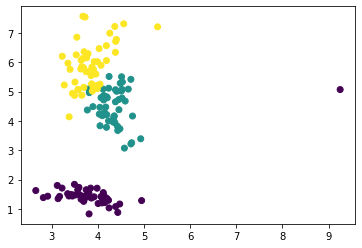

Epoch: 230 loss: 2.238300323486328


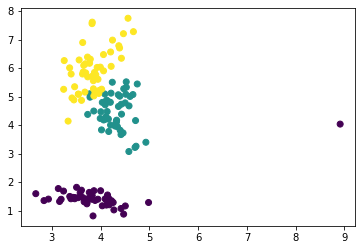

Epoch: 240 loss: 1.9562243223190308


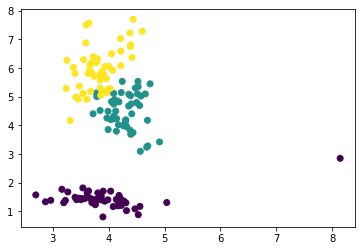

In [69]:
result = T_SNE(x,y)

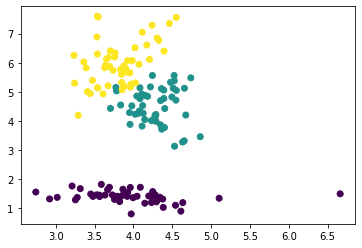

In [70]:
plt.scatter(result[:,0], result[:,1], c=y)
plt.show()

# 3D

In [89]:
result = T_SNE(x,y, num_dim=3)

3 (150, 4)
Epoch: 0 loss: 151.63267517089844
Epoch: 10 loss: 113.90052032470703
Epoch: 20 loss: 90.45616912841797
Epoch: 30 loss: 68.77991485595703
Epoch: 40 loss: 53.49995040893555
Epoch: 50 loss: 43.333106994628906
Epoch: 60 loss: 36.75727844238281
Epoch: 70 loss: 29.832605361938477
Epoch: 80 loss: 23.65220832824707
Epoch: 90 loss: 21.56818389892578
Epoch: 100 loss: 20.481779098510742
Epoch: 110 loss: 19.515689849853516
Epoch: 120 loss: 18.427413940429688
Epoch: 130 loss: 16.883710861206055
Epoch: 140 loss: 13.509316444396973
Epoch: 150 loss: 4.078841209411621
Epoch: 160 loss: 1.178189992904663
Epoch: 170 loss: 0.6607697606086731
Epoch: 180 loss: 0.3483727276325226
Epoch: 190 loss: 0.2050420641899109
Epoch: 200 loss: 0.15143199265003204
Epoch: 210 loss: 0.12499874830245972
Epoch: 220 loss: 0.10885497182607651
Epoch: 230 loss: 0.10045953840017319
Epoch: 240 loss: 0.09479876607656479


In [102]:
df = pd.DataFrame(data={
    "x":result[:,0],
    "y":result[:,1],
    "z":result[:,2],
    "class":y
})

fig = px.scatter_3d(df, x="x", y="y", z="z", color="class")
fig.show()